**Stat 542 - Statistical Learning**

**Fall 2022**

**Coding Assignment #2**

**Author: Paolo Furlanetto Ferrari**

**Date: September 26, 2022**

## Part I

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(3213)

**Load Data**

In [42]:
myData = pd.read_csv("Coding2_Data.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [43]:
X.shape, len(y)


((506, 13), 506)

**CD for Lasso**

In [44]:
def one_var_lasso(r, x, lam):
    a = (np.dot(np.transpose(r),x)/(np.dot(np.transpose(x),x)))
    lambd = 2*x.shape[0]*lam/(np.dot(np.transpose(x),x))   
    if a > lambd/2:
        return a - lambd/2
    elif a < -lambd/2:
        return a + lambd/2
    else:
        return 0
    
    

In [45]:
def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    newX = (X-np.mean(X,axis=0))/np.std(X, axis = 0)
    
    # (2) Record the centers and scales used in (1) 
    centers = np.mean(X,axis=0)
    scales = np.std(X, axis=0)
    ##############################

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y

    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    B[1:,] = np.transpose(np.transpose(B[1:,])/scales)
    # Update the intercepts stored in B[, 1] (B[0,]?)
    B[0,] = np.mean(y) - np.matmul(np.transpose(B[1:,]),centers) 
    
    ##############################
    
    
    return(B)

In [46]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.30999458351285203, 0.49974219884805027)

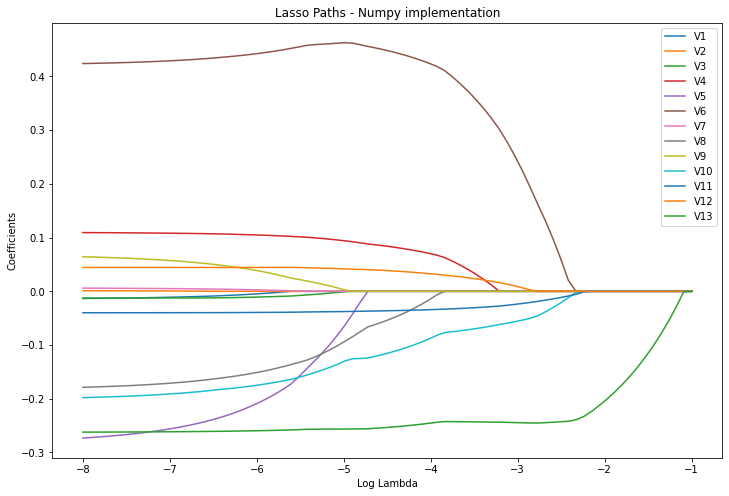

In [47]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

**Check the Accuracy**


In [48]:
lasso_coef = pd.read_csv("Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [49]:
abs(myout - lasso_coef).max()


0.004645317415915784

**Comment: The error is below 0.005!**

## Part II

## Case I

In [50]:
!pip install https://github.com/bbalasub1/glmnet_python/archive/refs/tags/1.0.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/bbalasub1/glmnet_python/archive/refs/tags/1.0.tar.gz


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import glmnet_python
from glmnet import glmnet
from cvglmnet import cvglmnet
from cvglmnetPredict import cvglmnetPredict
from cvglmnetPlot import cvglmnetPlot
from cvglmnetCoef import cvglmnetCoef

**Load Data**

In [52]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/F22/Coding2_Data2.csv"
myData = pd.read_csv(url)
var_names = myData.columns
Y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()


**Splitting Test and Train Data**

In [53]:
n = len(Y)
indices = np.arange(0, n)
np.random.shuffle(indices)
test_ind = indices[:int(np.floor(0.25*n))]
train_ind = indices[len(test_ind):]


**Model 1: All predictors included**

In [54]:
def full_model():

  full = LinearRegression().fit(X[train_ind, :], Y[train_ind])
  return np.mean((full.predict(X[test_ind, :]) - Y[test_ind])**2)

**Models 2 and 3: Ridge Regression**

In [55]:
def ridge():
  ridge_seq = np.exp(np.linspace(-2, -10, num=100))
  ridge_out = cvglmnet(x = X.copy(), y = Y.copy(), alpha = 0, lambdau = ridge_seq)
  ridge = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 0, lambdau = ridge_seq)
  pred = cvglmnetPredict(ridge, s = ridge['lambda_min'], newx=X[test_ind, :].copy())
  err1 = np.mean((Y[test_ind] - pred)**2)
  pred = cvglmnetPredict(ridge, s = ridge['lambda_1se'], newx=X[test_ind, :].copy())
  err2 = np.mean((Y[test_ind] - pred)**2)
  return err1, err2

**Models 4 and 5: Lasso**

In [56]:
def lasso_f():
  lasso_out = cvglmnet(x = X.copy(), y = Y.copy(), alpha = 1)
  lasso = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 1)
  pred = cvglmnetPredict(lasso, s = lasso['lambda_min'], newx=X[test_ind, :].copy())
  err1 = np.mean((Y[test_ind] - pred)**2)
  pred = cvglmnetPredict(lasso, s = lasso['lambda_1se'], newx=X[test_ind, :].copy())
  err2 = np.mean((Y[test_ind] - pred)**2)
  return err1, err2

**Model 6: Refit**



In [57]:
def refit():
  lasso = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 1)
  lasso_coef = cvglmnetCoef(lasso, s = 'lambda_1se')
  var_sel = np.nonzero(lasso_coef[1:])[0]
  tmp_train = X[train_ind[:,None], var_sel[None, :]]
  tmp_test = X[test_ind[:,None], var_sel[None, :]]
  refit_model = LinearRegression().fit(tmp_train, Y[train_ind])
  pred = refit_model.predict(tmp_test)
  return np.mean((pred - Y[test_ind])**2)

**Model 7: PCR**


In [58]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)
        
        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]
            
            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])
            
            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = LinearRegression().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)


In [59]:
def PCR_f():
  pcr = PCR()
  pcr.fit(X[train_ind, :], Y[train_ind])
  preds = pcr.predict(X[test_ind, :])
  return np.mean((Y[test_ind] - preds)**2)

**Running simulation 50 times**

In [60]:
N_Y = len(Y)
indices = np.arange(0, N_Y)
efull, eridge_min, eridge_se, elasso_min, elasso_se, erefit, epcr = np.zeros((7,50))

for i in range(50):
  np.random.shuffle(indices)
  test_ind = indices[:int(np.floor(0.25*N_Y))]
  train_ind = indices[len(test_ind):]
  efull[i] = full_model()
  eridge_min[i], eridge_se[i] = ridge()
  elasso_min[i], elasso_se[i] = lasso_f()
  erefit[i] = refit()
  epcr[i] = PCR_f()


**Questions**

b) Summarize your results on MSPE graphically, e.g., using boxplot or stripchart.

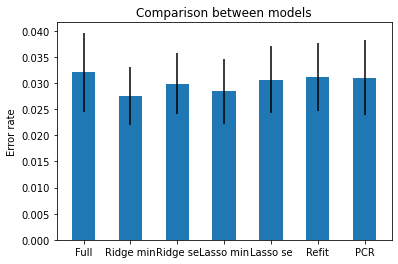

In [61]:
means = [np.mean(y) for y in [efull, eridge_min, eridge_se, elasso_min, elasso_se, erefit, epcr]]
stds = [np.std(y) for y in [efull, eridge_min, eridge_se, elasso_min, elasso_se, erefit, epcr]]
ind = [1, 2, 3, 4, 5, 6,7]
    

p2 = plt.bar(ind, means, width = 0.5, yerr=stds)
plt.ylabel('Error rate')
plt.title('Comparison between models')
plt.xticks(ind, ('Full', 'Ridge min', 'Ridge se', 'Lasso min', 'Lasso se', 'Refit', 'PCR'))
plt.show()

c) Based on your simulation results, answer the following questions:

i. Which method or methods perform the best?

ii. Which method or methods perform the worst?

iii. For Ridge regression, which, lambda.min or lambda.1se, produces better MSPE?

iv. For Lasso regression, which, lambda.min or lambda.1se, produces better MSPE?

v. Is it worth doing refit? That is, does L.Refit perform better than Lasso.1se?

vi. Is it worth doing variable selection or shrinkage in this case? That is, do you think the performance of Full is comparable or not to the best among the other six?

**Answers**

i. Based on average error rate, the best methods are Ridge min and Lasso min

ii. The Full, PCR and Refitting methods

iii. lambda.min

iv. lambda.min

v. It is not advantedgeous in the sense that the error bigger in the Refitted model. 

vi. Both Lasso and Ridge methods outperform the Full model, so it is definitely worth doing shrinkage.

## Case II

**Load data**

In [62]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/F22/Coding2_Data3.csv"
myData = pd.read_csv(url)
var_names = myData.columns
Y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [63]:
N_Y = len(Y)
indices = np.arange(0, N_Y)
eridge_min, eridge_se, elasso_min, elasso_se, erefit, epcr = np.zeros((6,50))

for i in range(50):
  np.random.shuffle(indices)
  test_ind = indices[:int(np.floor(0.25*N_Y))]
  train_ind = indices[len(test_ind):]
  eridge_min[i], eridge_se[i] = ridge()
  elasso_min[i], elasso_se[i] = lasso_f()
  erefit[i] = refit()
  epcr[i] = PCR_f()


**Questions**

b) Summarize your results on MSPE graphically, e.g., using boxplot or stripchart.


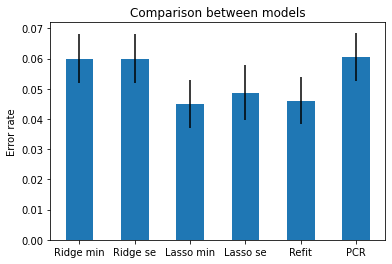

In [64]:
means = [np.mean(y) for y in [eridge_min, eridge_se, elasso_min, elasso_se, erefit, epcr]]
stds = [np.std(y) for y in [eridge_min, eridge_se, elasso_min, elasso_se, erefit, epcr]]
ind = [1, 2, 3, 4, 5, 6]
    

p2 = plt.bar(ind, means, width = 0.5, yerr=stds)
plt.ylabel('Error rate')
plt.title('Comparison between models')
plt.xticks(ind, ('Ridge min', 'Ridge se', 'Lasso min', 'Lasso se', 'Refit', 'PCR'))
plt.show()

c) Based on your simulation results, answer the following questions:

i. Which method or methods perform the best in this case?

ii. Which method or methods perform the worst in this case?

iii. Do you notice any method/methods that performs/perform better in one case but not in the other? If so, explain why.

iv. Since Coding2_Data3.csv contains all features in Coding2_Data2.csv, one may expect that the best MSPE in Case II is smaller than, or at least not bigger than, the the best MSPE in Case I. Do your simulation results support this expectation? If not, explain why.

**Answers**

i. Minimum Lasso and Refit are the best methods, with mean errors around 4.5%

ii. PCR and both Ridge methods are the worst, with mean errors close to 6%

iii. Ridge methods (specially Ridge min) seem to particularly perform worse in Case II vs Case I. This is a consequence of the fact that Ridge methods do not discard any feature, thus it fits all the noisy varibles as features of the model. Even though the coefficients of the noise are optimized for the traning set, they lead to increased errors in the test set.

iv. Overall the error rates are larger for the data set in Case II. In fact, the minimum error (for minimum Lasso, around 4.5%) is larger than all the error from all models in Case I. This is likely a result of the models capturing the wrong features (the noise) as predictors in the training set, which of course lead to performing bad in the test set.